# Noisy logistic map
We study the noisy logistic map, a non-linear dynamical system defined by the recursive relation $x_{t + 1} = (4x_{t}(1 - x_{t}) + \xi_{t}) \mod 1$ over the state space $\mathcal{X} = [0 , 1]$. Here, $\xi_{t}$ is i.i.d. additive _trigonometric_ noise as defined in~\cite{Ostruszka2000}. The probability distribution of trigonometric noise is supported in $[-0.5,0.5]$ and is proportional to $\cos^{N}(\pi\xi)$, $N$ being an {\em even} integer. In this setting, the true invariant distribution, transition kernel and Koopman eigenvalues are easily computed. 


In Tab.~\ref{tab:logistic_map_results} we compare the performance of KRR, PCR and RRR (see Sec.~\ref{sec:erm}) trained with a Gaussian kernel. We average over 100 different training datasets each containing $10^{4}$ data points and evaluate the test error on 500 unseen points. In Tab.~\ref{tab:logistic_map_results} we show the approximation error for the three largest eigenvalues of the Koopman operator, $\lambda_{1} = 1$ and $\lambda_{2,3} = -0.193 \pm 0.191i$ as well as training and test errors. The following eigenvalues $|\lambda_{4,5}| \approx 0.027$ are an order of magnitude smaller than $|\lambda_{2,3}|$.  Both PCR and RRR have been trained with the rank constraint $r=3$. The regularization parameter $\gamma$ for KRR and RRR is the value $\gamma \in [10^{-7}, 1]$ minimizing the validation error. The RRR estimator always outperforms PCR, and in the estimation of the non-trivial eigenvalues $\lambda_{2,3}$ ($\lambda_{1}$ corresponding to the equilibrium mode is well approximated by every estimator) attains the best results. In Fig.~\ref{fig:uniform_bound_logistic} we report the results of a comparison between PCR and RRR performed under Ivanov regularization. This experiment was designed to empirically test the uniform bounds presented in Sec.~\ref{sec:bounds}. Again, RRR consistently outperforms the PCR estimator.

### Getting the data

In [64]:
import numpy as np
import scipy.linalg
import kooplearn
import logging
from sklearn.gaussian_process.kernels import RBF
from kooplearn.datasets.stochastic import LogisticMap
logging.basicConfig(level=logging.INFO)

map = LogisticMap(N = 20, rng_seed = 0) #Setting rng_seed for reproducibility
dataset = map.generate(X0 = np.array([0.5]), T = 10000)

#Splitting the trajectory into inputs and outputs
X = dataset[:-1]
Y = dataset[1:]

### Extended DMD with polynomials
[... let ChatGPT write this ...]

In [65]:
#Subclassing kooplearn.abc.FeatureMap
class PolyFeatures(kooplearn.abc.FeatureMap):
    def __init__(self, order: int = 3) -> None:
        super().__init__()
        self.order = order
    
    def __call__(self, X: np.ndarray) -> np.ndarray:
        return np.concatenate([X**i for i in range(1, self.order + 1)], axis=1)
#Instantiating the feature map
feature_map = PolyFeatures(order = 5)
print(feature_map(X)[:5])

[[5.00000000e-01 2.50000000e-01 1.25000000e-01 6.25000000e-02
  3.12500000e-02]
 [2.46144751e-02 6.05872382e-04 1.49132306e-05 3.67081344e-07
  9.03551458e-09]
 [5.29796468e-02 2.80684297e-03 1.48705549e-04 7.87836747e-06
  4.17393126e-07]
 [7.99330460e-02 6.38929185e-03 5.10715559e-04 4.08230503e-05
  3.26311076e-06]
 [1.47134709e-01 2.16486225e-02 3.18526378e-03 4.68662858e-04
  6.89565732e-05]]


### Running the model

In [70]:
edmd = kooplearn.ExtendedDMD(feature_map = feature_map, tikhonov_reg=1e-5)
edmd.fit(X, Y)

kdmd = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), rank = 3, tikhonov_reg=1e-5, svd_solver='arnoldi')
kdmd.fit(X, Y)

INFO:root:Rank of the estimator set to 5


/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:57: RuntimeWarning: invalid value encountered in matmul
  norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X


In [89]:
kdmd_PCR = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), reduced_rank=False, rank = 5, tikhonov_reg=1e-5, svd_solver='arnoldi')
kdmd_PCR.fit(X, Y)

### Plotting the results

In [71]:
import matplotlib.pyplot as plt
def plot_eigs(models: list):
    _, ax = plt.subplots()
    for _model_dict in models:
        model = _model_dict.pop('model')
        ax.scatter(model.eig().real, model.eig().imag,  **_model_dict)
    #Add the unit circle
    circ = plt.Circle((0, 0), radius=1, linestyle='--', edgecolor='k', facecolor='None')
    ax.add_patch(circ)
    #Set the axes to be equal
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.legend()

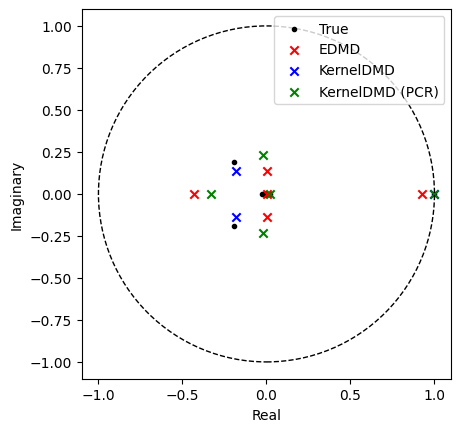

In [90]:
models = [
    {
        'model': map,
        'label': 'True',
        'marker': '.',
        'c': 'k',
    },
    {
        'model': edmd,
        'label': 'EDMD',
        'marker': 'x',
        'c': 'r',
    },
    {
        'model': kdmd,
        'label': 'KernelDMD',
        'marker': 'x',
        'c': 'b',
    },
    {
        'model': kdmd_PCR,
        'label': 'KernelDMD (PCR)',
        'marker': 'x',
        'c': 'g',
    },
]
plot_eigs(models)

In [85]:
n_grid = 500
_grid = np.linspace(-.3, .3, n_grid)
real, imag = np.meshgrid(_grid, _grid)
z_list = real.flatten() + 1j * imag.flatten()
vals = [np.min(scipy.linalg.svdvals(map._A - z*np.eye(*map._A.shape))) for z in z_list]
vals = np.array(vals).reshape(n_grid, n_grid)

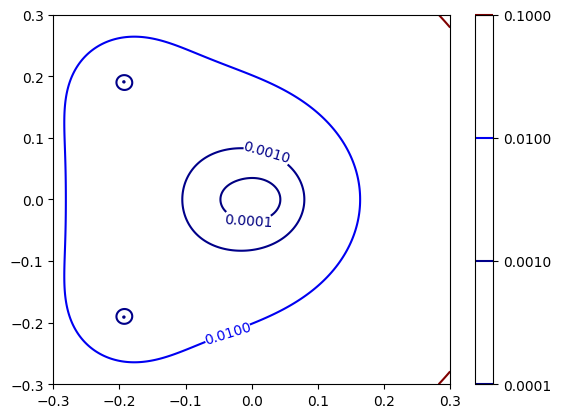

In [86]:
from matplotlib import ticker
fig, ax = plt.subplots()
CS = ax.contour(real, imag, vals, levels = [1e-4, 1e-3, 1e-2, 1e-1], cmap='jet')
ax.clabel(CS, inline=True, fontsize=10)
plt.colorbar(CS)


In [92]:
svals=scipy.linalg.svdvals(map._A)

In [93]:
svals[:11].sum()

3.7498362801350504

In [ ]:
#TODO for pie - DPNets with hausdorff distance between spetra.